<a href="https://colab.research.google.com/github/NerijusSh/demo/blob/main/%E2%80%9E215_ipynb%E2%80%9C_kopija.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module 2: Data Analysis
## Sprint 1: Introduction to SQL & Statistics Fundamentals
## Part 5: Analysis of the Mental Health in the Tech Industry


## About this Part

Congrats!
You have reached the last Part of this Sprint.
In this Part, you will put what you learned during this and the previous Sprints into practice.
As the final assignment of this Sprint, you will analyse the Mental Health in the Tech Industry Dataset.
You will have to apply all that you have learned about SQL, Statistics, and Data Analysis to complete this task.
Our expectation is that you'll use your own judgement how to perform the analysis and how to select the most important avenues of exploration.
You'll have to iteratively raise hypotheses and use your data analysis skills to get answers.

## Objectives for this Part

- Practice working with SQLite datasets.
- Practice performing EDA.
- Practice visualizing data with Matplotlib & Seaborn.
- Practice reading data, performing queries and filtering data using SQL and Pandas.

## Requirements

- Download the data from [Mental Health in the Tech Industry](https://www.kaggle.com/anth7310/mental-health-in-the-tech-industry).
- Load the data using SQLite and Pandas.
- Perform exploratory data analysis. This should include creating statistical summaries and charts, testing for anomalies, checking for correlations and other relations between variables, and other EDA elements.
- Provide clear explanations in your notebook. Your explanations should inform the reader what you are trying to achieve, what results did you get, and what these results mean.
- Provide suggestions about how your analysis can be improved.

## Evaluation Criteria

- Adherence to the requirements. How well did you meet the requirements?
- Depth of your analysis. Did you just skim the surface or did you explored the dataset in depth?
- Visualization quality. Did you use charts effectively to visualize patterns in the data? Are your visualizations properly labeled? Did you use colors effectively? Did you adhere to the principle of proportional ink?
- Code quality. Was your code well-structure? Did you use the appropriate levels of abstraction? Did you remove commented out and unused code? Did you adhere to the PEP8?
- Code performance. Did you use the suitable algorithms and data structures to solve the problems?

## Sample Correction Questions

During a correction, you may get asked questions that test your understanding of covered topics.

- What are the main types and subtypes of data?
- What are the main metrics of location? What advantages and disadvantages each of them have?
- What is variability? What are the main metrics of variability? What advantages and disadvantages each of them have?
- What is correlation? How do we use it to analyse data?
- What is a contingency table?


# Intro

My goal of this project is to explore the data we have and mainly compare Europe's and North America's culture on mental health problems at work and answer which of these two continents is better at dealing with these problems.

# Loading the dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3 as sql
from scipy.stats import chisquare

In [ ]:
sns.set_style("darkgrid")
sns.set_context("talk")

In [ ]:
con = sql.connect('mental_health.sqlite')
survey_df = pd.read_sql('SELECT * FROM Survey', con)
questions_df = pd.read_sql('SELECT * FROM Question', con)
answers_df = pd.read_sql('SELECT * FROM Answer', con)
answers_df.columns = ['AnswerText', 'SurveyID',	'UserID', 'questionid']

In [ ]:
qna_df = pd.merge(answers_df, questions_df, how ='left', on='questionid')

Merging answers and questions tables into one.

In [ ]:
qna_df['AnswerText'] = qna_df['AnswerText'].str.lower()

Making all string answers to lower cases so there aren't any "different" answers that mean the same thing.

In [ ]:
qna_df.drop(qna_df[qna_df['AnswerText'] == '-1'].index, inplace=True)

As far as I understood "-1" means the question was skipped or not answered in general so I decided to drop those answers.

In [ ]:
qna_df.dropna(inplace=True)

Also dropping all NA's.

I made some functions that would save me some time finding answers, keys and values as well as merging different questions.

In [ ]:
def find_answers(x):
  return qna_df.loc[qna_df['questionid'] == x][['UserID','AnswerText']]

def merge_answers(question1, question2):
    return pd.merge(qna_df.loc[qna_df['questionid'] == question1][['UserID', 'AnswerText']],
            qna_df.loc[qna_df['questionid'] == question2][['UserID', 'AnswerText']],
            how ='inner', on='UserID')

def get_tuple_values(given_tuple, index=0):
    return [given_tuple[i][index] for i in range(len(given_tuple))]

Also graphing functions

In [ ]:
def bar_chart(x_value, y_value, xlabel, ylabel, title, yticks, x, y):
    fig,ax = plt.subplots(figsize=(x,y))

    g = sns.barplot(x=x_value,
                y=y_value,
                ax=ax
                )
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yticks(yticks) 

    plt.title(title)
    return plt.show()

In [ ]:
def stacked_bar_chart(data, x, y, title, yticks, ylabel, l_labels):
    ax = data.plot(kind='bar', stacked=True, figsize=(x,y))

    for p in ax.patches:
        height = p.get_height()
        width = p.get_width()
        x = p.get_x()
        y = p.get_y()

        label_text = f'{height:.1f}%'
        
        label_x = x + width / 2
        label_y = y + height / 2

        if height > 0:
            ax.text(label_x, label_y, label_text,
                    ha='center', va='center', fontsize=16)

    plt.title(title)
    plt.ylabel(ylabel)
    plt.yticks(yticks)
    plt.xticks(rotation=0)
    plt.legend(labels=l_labels, loc='best', title='')
    return plt.show() 

In [ ]:
def grouped_bar_chart(data, x, y, title, xlabel, ylabel, yticks, move_x,
                      fontsize, units):
    ax = data.plot(kind='bar', stacked=False, figsize=(x,y))

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yticks(yticks) 
    plt.xticks(rotation=0, ha='center')
    plt.legend(labels=data.columns.str.capitalize(),
               loc='best', title='')

    for p in ax.patches:
        ax.annotate(str(p.get_height())+units,
                    (p.get_x() * 1.005+move_x, p.get_height() * 1.005+0.01),
                    fontsize=fontsize)

    return plt.show()

# EDA

To do the exploratory data analysis first thing we need to know is what kind of data we have ? How old are the survey participants ? Where do they live ?

## When was this survey conducted?

In [ ]:
str(qna_df['SurveyID'].unique())

'[2014 2016 2017 2018 2019]'

Now we know the years survey questions we're about to analyse were asked.

## Age

In [ ]:
age_group = find_answers(1)

In [ ]:
age_group = age_group['AnswerText'].astype('int')

In [ ]:
age_group.describe().apply(lambda x: format(x, 'n'))

count       4213
mean     33.9568
std      10.4149
min          -29
25%           28
50%           33
75%           38
max          329
Name: AnswerText, dtype: object

We see that we have some anomalies in our participats age data: our min value is -29 and max value is 329. We need to fix that.

In [ ]:
age_group.drop(age_group[(age_group < 18) | (age_group > 90)].index,
               inplace = True)

Because our survey is about people who do work in companies I decided that the age range should be from 18 years old to 90 years old.

In [ ]:
age_group.isna().any()

False

Just to make sure we check if dataset doesn't have any duplicates as we already dropped them before.

In [ ]:
age_group.describe().apply(lambda x: format(x, 'n'))

count       4202
mean     33.8598
std      8.06502
min           18
25%           28
50%           33
75%           38
max           74
Name: AnswerText, dtype: object

After cleaning anomalies we see that we have 25% aged 18-28, 50% 28-38 years old and 25% 38-74. Also we know that 75%+ of our respondents to the survey are younger than 40 years. It is important to know that because our survey is about mental health where age is a key factor.

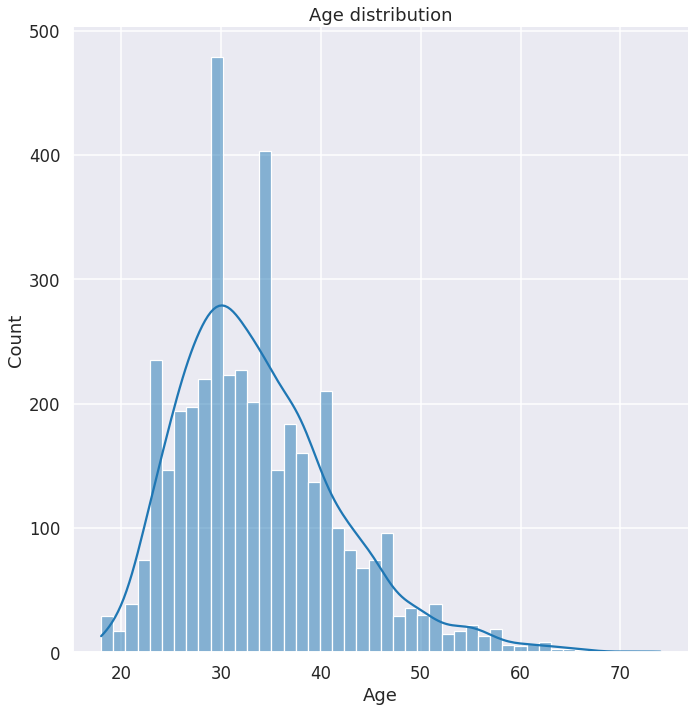

In [ ]:
sns.displot(data=age_group, kde=True, height=10)

plt.title('Age distribution')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

Distribution is right skewed.

## Gender

In [ ]:
gender_group = find_answers(2)

In [ ]:
gender_group = gender_group.drop(gender_group[gender_group['AnswerText'].str.contains(r'\d')]
                                 .index)

In [ ]:
gender_group = gender_group['AnswerText']

In [ ]:
males_grp = gender_group.isin(['male']).sum()
females_grp = gender_group.isin(['female']).sum()
other_grp = len(gender_group) - males_grp - females_grp

gender_arr = [males_grp, females_grp, other_grp]

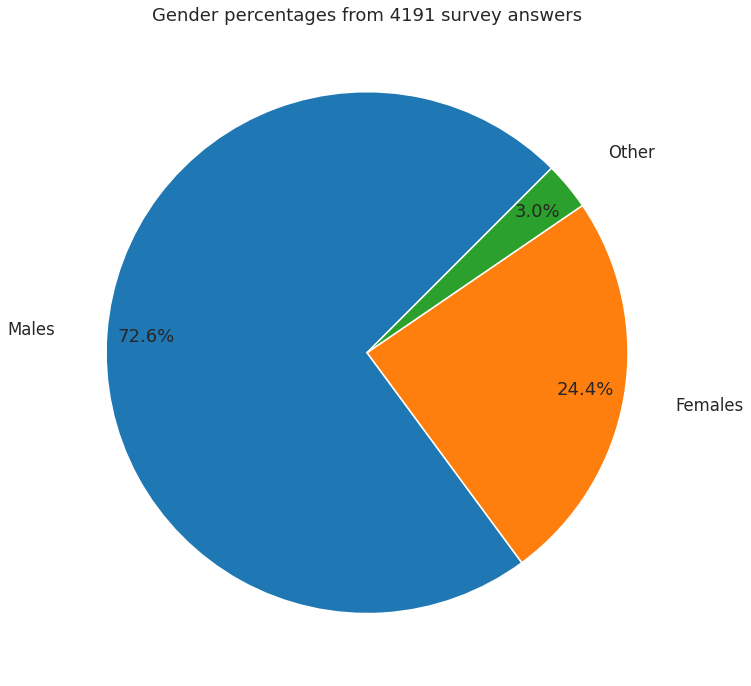

In [ ]:
fig=plt.figure(figsize=(12,12))
data=[x/len(gender_group) for x in gender_arr]
labels=['Males', 'Females', 'Other']

colors=sns.color_palette()

plt.pie(data,
        labels=labels,
        colors=colors,
        autopct='%.1f%%',
        startangle=45,
        pctdistance=0.85,
        labeldistance=1.2
        )
plt.title(f'Gender percentages from {len(gender_group)} survey answers')

plt.show()

We see that 73% of survey participants are males and 24% percent are females and 3% are of other gender.

## Tech industry vs Non tech industry

It is known that people who work in tech industry more often has to deal with mental health issues compared to other industries. Let's see if that's the case in this survey aswell.

In [ ]:
tech_df = merge_answers(9, 33)

In [ ]:
tech_df['AnswerText_x'] = tech_df['AnswerText_x'].astype('int')

In [ ]:
tech_count = tech_df['AnswerText_x'].sum()

In [ ]:
tech_sick_count = len(tech_df.loc[~(tech_df['AnswerText_x'] == 0)
                  & ~(tech_df['AnswerText_y'] == "no")
                  & ~(tech_df['AnswerText_y'] == "don't know")])

In [ ]:
no_tech_count = len(tech_df) - tech_count
no_tech_sick_count = len(tech_df.loc[(tech_df['AnswerText_x'] == 0)
                  & ~(tech_df['AnswerText_y'] == "no")
                  & ~(tech_df['AnswerText_y'] == "don't know")])

In [ ]:
print(f'Roughly 3 out of {int((tech_count/tech_sick_count*3).round(1))} people who work in tech industry has/thinks that they have some mental disorder.')
print(f"Also according to this survey 3 out of {int(no_tech_count/no_tech_sick_count*3)} people who DON'T work in tech industry has/thinks that they have some mental disorder.")

Roughly 3 out of 4 people who work in tech industry has/thinks that they have some mental disorder.
Also according to this survey 3 out of 4 people who DON'T work in tech industry has/thinks that they have some mental disorder.


We see that 75% of people who answered to this questions has or thinks that they have some kind of mental illness. So according to this survey it doesn't matter whether you're in tech industry or not, rates of people having/feeling that they have mental illnesses are the same.

## Hypothesis testing

Some mental disorders are congenital and inherited from ancestors. I tried finding out whether questions "Do you have a family history of mental illness?" and "Do you currently have a mental disorder?" are correlated and not independent of one another.

In [ ]:
family_history = find_answers(6)['AnswerText'].str.capitalize().value_counts()

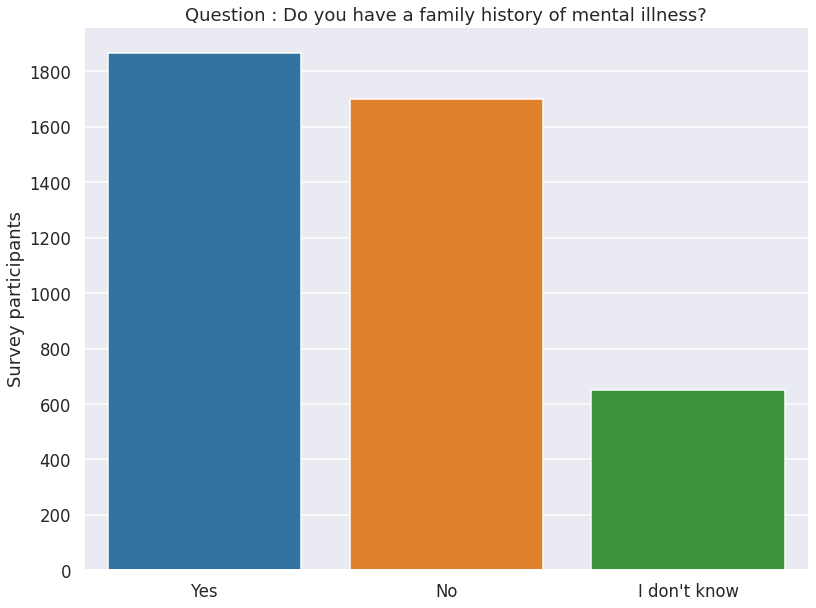

In [ ]:
bar_chart(family_history.index, family_history, '', 'Survey participants',
          'Question : Do you have a family history of mental illness?',
          np.arange(0, 2000, 200), 13, 10)

In [ ]:
mental_disorders = find_answers(33)['AnswerText'].str.capitalize().value_counts()

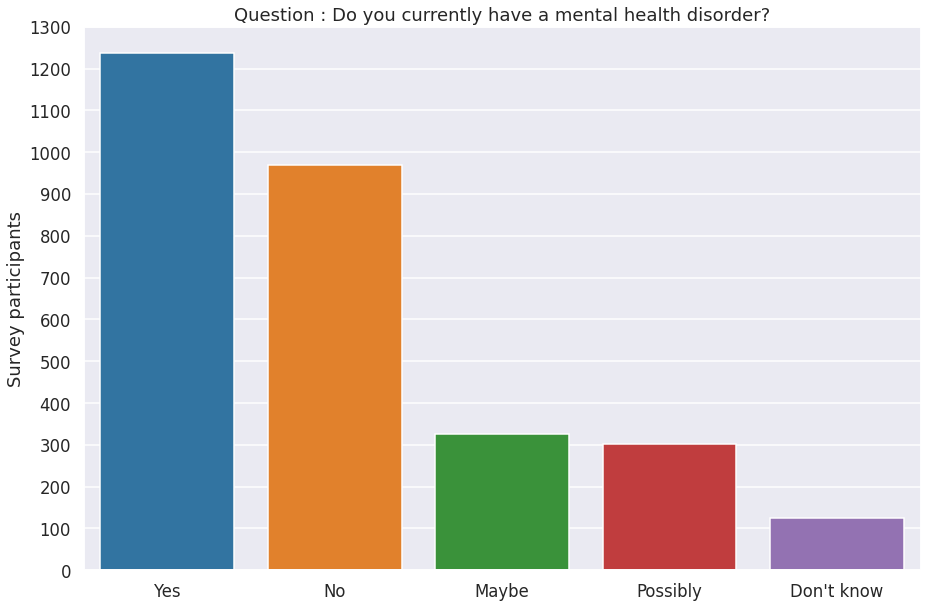

In [ ]:
bar_chart(mental_disorders.index, mental_disorders, '', 'Survey participants',
          'Question : Do you currently have a mental health disorder?',
          np.arange(0, 1400, 100), 15, 10)

In [ ]:
family_df = merge_answers(6, 33)

In [ ]:
my_counts = np.array(family_df[['AnswerText_x', 'AnswerText_y']].value_counts())

First we have to calculate chisquare value.

In [ ]:
chi_value = chisquare(my_counts)[0]
chi_value

3253.977687626775

Because $\chi_{0.05}^2(8) = 15.507 < 3253.977 = \chi^2$\
we drop the hypothesis about these two features being independent, and we accept the hypothesis that they are dependent (Although that's the case in most hypotheses where n >> 1000).

Then we need to know how many data points we have.

In [ ]:
family_n = my_counts.sum()
family_n

2958

Also we need to know df which is degree's of freedom.

In [ ]:
df_1 = min(family_df['AnswerText_x'].nunique(), family_df['AnswerText_y'].nunique()) - 1
df_1

2

When we have all the values we put them into the formula and get our Cramer's V coefficient.

In [ ]:
cramersV_1 = (chi_value/(family_n*df_1))**0.5
cramersV_1

0.7416400980905791

The value we got is quite big so we can say that these two questions are strongly associated.

## Continent

It's important to know where from which part of the world answers of this survey comes from. To do that I sorted them by continents depending on which country the respondent is from.

In [ ]:
country_group = find_answers(3)['AnswerText']

In [ ]:
africa_list = ['Algeria','Angola','Benin','Botswana','Burkina','Burundi',
               'Cameroon','Cape Verde','Central n Republic','Chad','Comoros',
               'Congo','Djibouti','Egypt','Equatorial Guinea','Eritrea',
               'Ethiopia','Gabon','Gambia','Ghana','Guinea','Guinea-Bissau',
               'Ivory Coast','Kenya','Lesotho','Liberia','Libya','Madagascar',
               'Malawi','Mali','Mauritania','Mauritius','Morocco','Mozambique',
               'Namibia','Niger','Nigeria','Rwanda','Sao Tome and Principe',
               'Senegal','Seychelles','Sierra Leone','Somalia','South Sudan',
               'Sudan','Swaziland','Tanzania','Togo','Tunisia','Uganda',
               'Zambia','Zimbabwe', 'South Africa']

In [ ]:
asia_list = ['Afghanistan','Bahrain','Bangladesh','Bhutan','Brunei',
             'Burma (Myanmar)','Cambodia','China','East Timor','India',
             'Indonesia','Iran','Iraq','Israel','Japan','Jordan','Kazakhstan',
             'North Korea','South Korea','Kuwait','Kyrgyzstan','Laos','Lebanon',
             'Malaysia','Maldives','Mongolia','Nepal','Oman','Pakistan',
             'Philippines','Qatar','Russia','Saudi Arabia',
             'Singapore','Sri Lanka','Syria','Tajikistan','Thailand','Turkey',
             'Turkmenistan','United Arab Emirates','Uzbekistan','Vietnam',
             'Yemen', 'Hong Kong', 'Taiwan']

In [ ]:
europe_list = ['Albania','Andorra','Armenia','Austria','Azerbaijan','Belarus',
               'Belgium','Bosnia And Herzegovina','Bulgaria','Croatia','Cyprus',
               'Czech Republic','Denmark','Estonia','Finland','France',
               'Georgia','Germany','Greece','Hungary','Iceland','Ireland',
               'Italy','Latvia','Liechtenstein','Lithuania','Luxembourg',
               'Macedonia','Malta','Moldova','Monaco','Montenegro',
               'Netherlands','Norway','Poland','Portugal','Romania','San Marino',
               'Serbia','Slovakia','Slovenia','Spain','Sweden','Switzerland',
               'Ukraine','United Kingdom','Vatican City']

In [ ]:
n_america_list = ['Antigua and Barbuda','Bahamas','Barbados','Belize','Canada',
                  'Costa Rica','Cuba','Dominica','Dominican Republic',
                  'El Salvador','Grenada','Guatemala','Haiti','Honduras',
                  'Jamaica','Mexico','Nicaragua','Panama',
                  'Saint Kitts and Nevis','Saint Lucia',
                  'Saint Vincent and the Grenadines','Trinidad and Tobago',
                  'United States Of America', 'United States']

In [ ]:
oceania_list = ['Australia','Fiji','Kiribati','Marshall Islands','Micronesia',
                'Nauru','New Zealand','Palau','Papua New Guinea','Samoa',
                'Solomon Islands','Tonga','Tuvalu','Vanuatu']

In [ ]:
s_america_list = ['Argentina','Bolivia','Brazil','Chile','Colombia','Ecuador',
                  'Guyana','Paraguay','Peru','Suriname','Uruguay','Venezuela']

Making a dictionary where keys are continents and values are how many people are from these continents so I can later plot it.

In [ ]:
region_dict = {
    'Europe' : 0,
    'North America' : 0,
    'Asia' : 0,
    'Oceania' : 0,
    'South America' : 0,
    'Africa' : 0,
}

In [ ]:
for country in country_group:
  if country.title() in europe_list:
    region_dict['Europe'] += 1
  elif country.title() in africa_list:
    region_dict['Africa'] += 1
  elif country.title() in asia_list:
    region_dict['Asia'] += 1
  elif country.title() in s_america_list:
    region_dict['South America'] += 1
  elif country.title() in n_america_list:
    region_dict['North America'] += 1
  elif country.title() in oceania_list:
    region_dict['Oceania'] += 1

In [ ]:
def find_na_eu(row):
    if row['AnswerText'].title() in n_america_list:
        return 'North America'
    elif row['AnswerText'].title() in europe_list:
        return 'Europe'

Function to find countries that are in EU/NA

In [ ]:
country_continent = find_answers(3)
country_continent['Continent'] = country_continent.apply(lambda row:
                                                         find_na_eu(row),
                                                         axis=1)

Making a country/continent dataframe that I will use a lot later on.

In [ ]:
country_continent.dropna(inplace=True)

In [ ]:
region_tuple = sorted(region_dict.items(), key=lambda x: x[1], reverse = True)

In [ ]:
region_keys = get_tuple_values(region_tuple)
region_vals = get_tuple_values(region_tuple, 1)

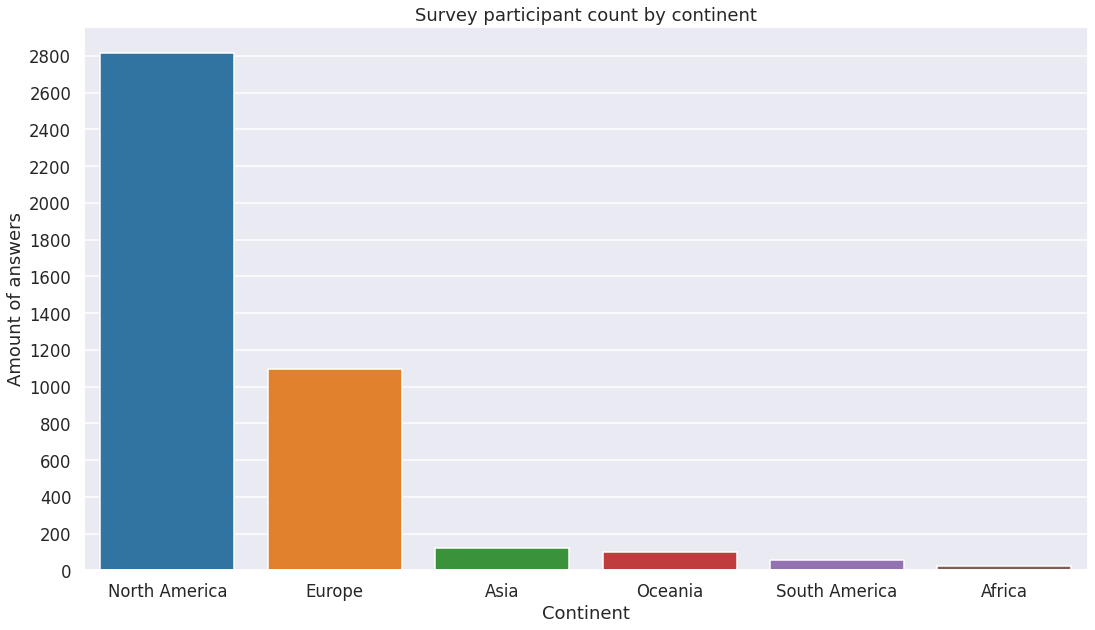

In [ ]:
bar_chart(region_keys, region_vals, 'Continent', 
          'Amount of answers', 'Survey participant count by continent',
          np.arange(0, 2900, 200), 18, 10)

We see that most of our participats are from North America and Europe. Only a small portion of respodents are from Asia, Oceania, South America and Africa.

## Europe vs North America

Since most of our data is from these two continents I decided to look deeper into them - tried finding common and different features and tired answering why things are the way they are in these continents

### Diagnosed with mental health disorders

When comparing two continents and their respondents about mental health first thing we should know what portion of them are diagnosed with mental illnesses.

In [ ]:
country_mental = find_answers(34)

In [ ]:
country_mental = pd.merge(country_continent, country_mental,
                          how='inner', on='UserID')

In [ ]:
country_mental_normalized = (country_mental.groupby('Continent')['AnswerText_y']
                             .value_counts(normalize=True)*100).round(1)

In [ ]:
country_mental_normalized = (country_mental_normalized
                             .unstack().reindex(columns=["yes","no"]))

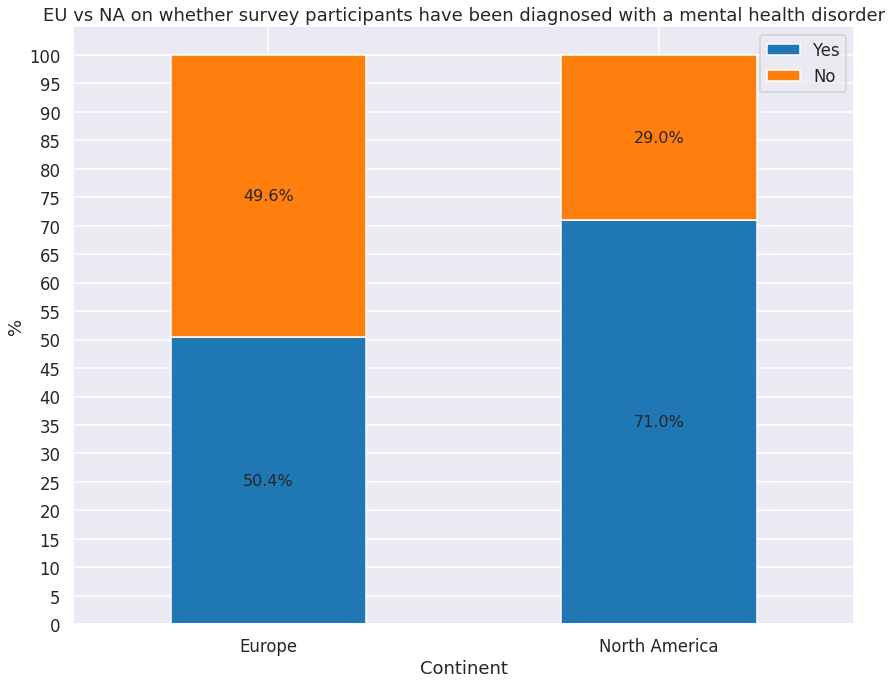

In [ ]:
stacked_bar_chart(country_mental_normalized, 14, 11,
                  'EU vs NA on whether survey participants have been diagnosed with a mental health disorder',
                  np.arange(0, 105, 5), '%', ["Yes", "No"])

In this dataset 50% of European respondents say that they have been diagnozed with some sort of mental illness compared to 71% of Americans. It is clear that in this dataset bigger percentage of Americans have mental illnesses compared to Europeans.

### Mental healthcare benefits

#### Employee count vs mental healthcare benefits


We know that some work places have mental health benefits as part of their healthcare coverage, what we don't know is how often these workplaces have them.

In [ ]:
benefits_df = merge_answers(8,10)

In [ ]:
benefits_df['AnswerText_y'].replace("don't know", "i don't know", inplace=True)

In [ ]:
size_options = list(benefits_df['AnswerText_x'].unique())

In [ ]:
benefits_dict = {}
for size in size_options:
    percentage = len(benefits_df.loc[(benefits_df['AnswerText_x'] == size) 
    & (benefits_df['AnswerText_y'] == 'yes')])/len(benefits_df.loc[benefits_df['AnswerText_x'] == size])
    benefits_dict[size] = round(percentage*100, 1)

In [ ]:
benefits_tuple = sorted(benefits_dict.items(), key=lambda x: x[1], reverse = True)

In [ ]:
benefits_keys = get_tuple_values(benefits_tuple)
benefits_vals = get_tuple_values(benefits_tuple, 1)

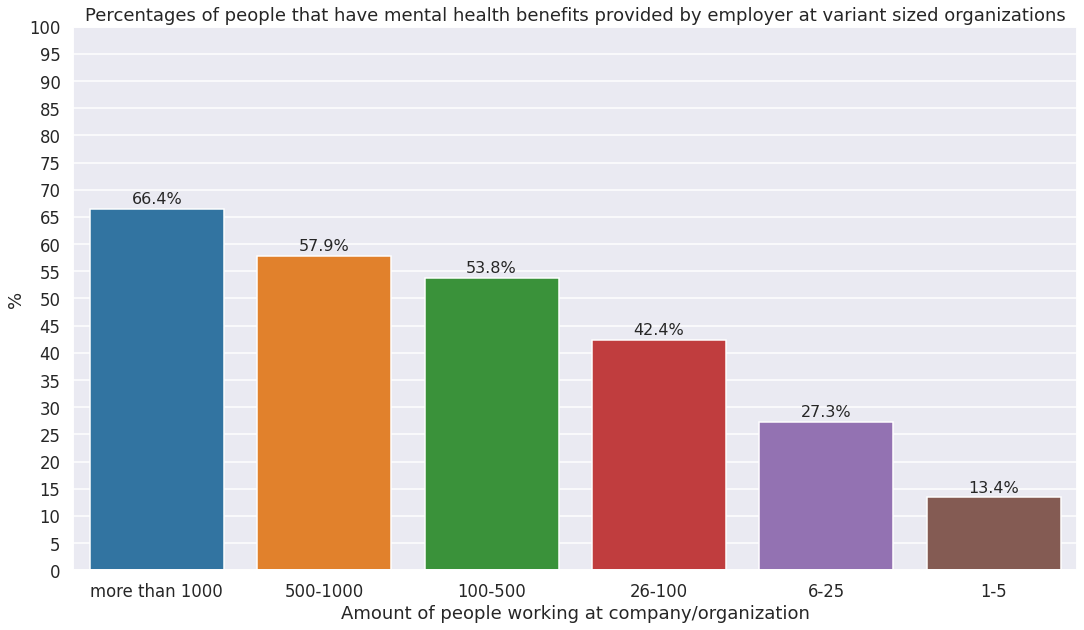

In [ ]:
fig, ax = plt.subplots(figsize=(18,10))

g = sns.barplot(x=benefits_keys,
            y=benefits_vals,
            ax=ax
            )

for index,data in enumerate(benefits_vals):
    plt.text(x=index , y=data+1 , s=f"{data}%" , fontdict=dict(fontsize=16),
             ha='center')

plt.ylabel('%')
plt.xlabel('Amount of people working at company/organization')
plt.yticks(np.arange(0, 105, 5))
plt.title('Percentages of people that have mental health benefits provided by employer at variant sized organizations')
plt.show()

We see a tendency here - the more employees a company has, the more likely it is for employee to have mental health benefits.

#### Mental healthcare benefits in EU and NA

Also what we don't know is if companies in different continents have dissimilar rates of having mental healthcare benefits.

In [ ]:
country_benefits = find_answers(10)

In [ ]:
country_benefits = pd.merge(country_continent, country_benefits,
                            how='inner', on='UserID')

In [ ]:
country_benefits['AnswerText_y'].replace("don't know", "i don't know", inplace=True)

In [ ]:
country_benefits_normalized = (country_benefits
                               .groupby('Continent')['AnswerText_y']
                               .value_counts(normalize=True)*100).round(1)

In [ ]:
country_benefits_normalized = (country_benefits_normalized
                               .unstack()
                               .reindex(columns=["yes","no",
                                                 "i don't know",
                                                 "not eligible for coverage / na"]))

In [ ]:
def grouped_bar_chart(data, x, y, title, xlabel, ylabel, yticks, move_x,
                      fontsize, units):
    ax = data.plot(kind='bar', stacked=False, figsize=(x,y))

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.yticks(yticks) 
    plt.xticks(rotation=0, ha='center')
    plt.legend(labels=data.columns.str.capitalize(),
               loc='best', title='')

    for p in ax.patches:
        ax.annotate(str(p.get_height())+units,
                    (p.get_x() * 1.005+move_x, p.get_height() * 1.005+0.01),
                    fontsize=fontsize)

    return plt.show()

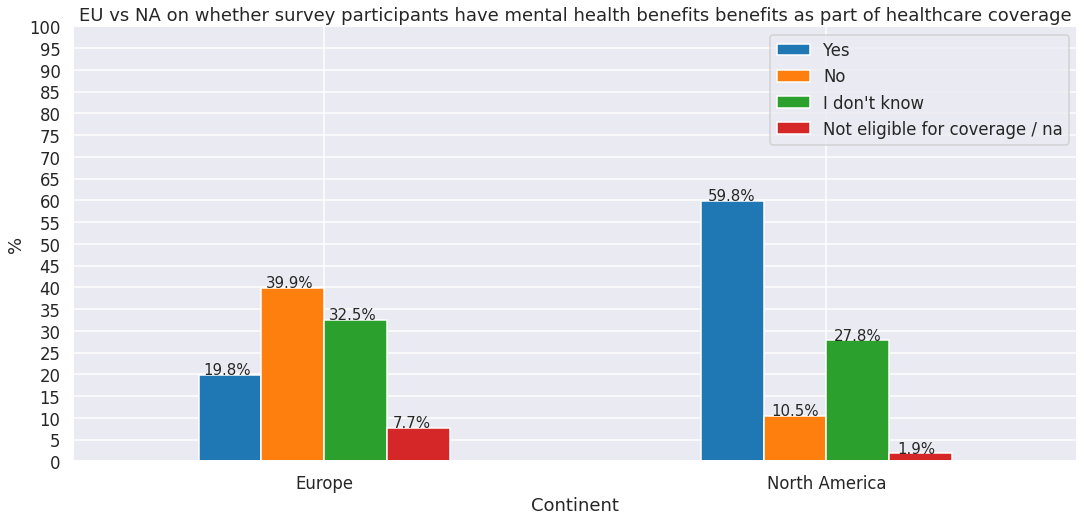

In [ ]:
grouped_bar_chart(country_benefits_normalized, 18, 8,
                  'EU vs NA on whether survey participants have mental health benefits benefits as part of healthcare coverage',
                  'Continent', '%', np.arange(0, 105, 5), 0.01, 15, '%')

In this dataset roughly 1 in 5 European people have mental healhcare benefits provided compared to 3 in 5 North Americans that have these benefits. We see that in Europe significantly smaller portion of people have mental healthcare benefits provided by their employers compared to North America. The difference between EU and NA on this matter is suspiciously big. Why might that be ? Let's find out.

In [ ]:
merged_benefits = pd.merge(benefits_df, country_benefits, how='inner', on='UserID')
merged_benefits_normalized = (merged_benefits
                              .groupby('Continent')['AnswerText_x_x']
                              .value_counts(normalize=True)*100).round(1)

In [ ]:
merged_benefits_normalized = (merged_benefits_normalized
                              .unstack()
                              .reindex(columns=['more than 1000', 
                                                '500-1000', '100-500', 
                                                '26-100', '6-25', '1-5']))

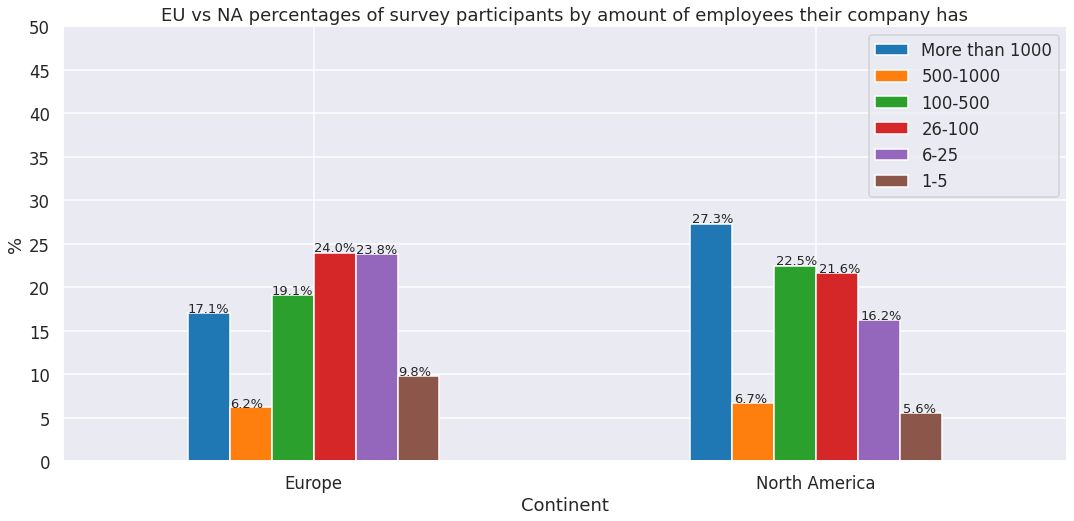

In [ ]:
grouped_bar_chart(merged_benefits_normalized, 18, 8,
                  'EU vs NA percentages of survey participants by amount of employees their company has',
                  'Continent', '%', np.arange(0, 55, 5), 0, 13, '%')

The answer to previously raised questions is quite simple and lies here. We see that in this survey bigger percetage of people from America works in larger companies that more oftenly provide mental healthcare benefits.

### Medical coverage

In [ ]:
coverage = find_answers(20)

In [ ]:
coverage_continent = pd.merge(country_continent, coverage,
                              how='inner', on='UserID')

In [ ]:
cov_cont_count = (coverage_continent
                  .groupby('Continent')['AnswerText_y']
                  .value_counts(normalize=True)*100).round(1)

In [ ]:
cov_plot = cov_cont_count.unstack().reindex(columns=["1", "0"])

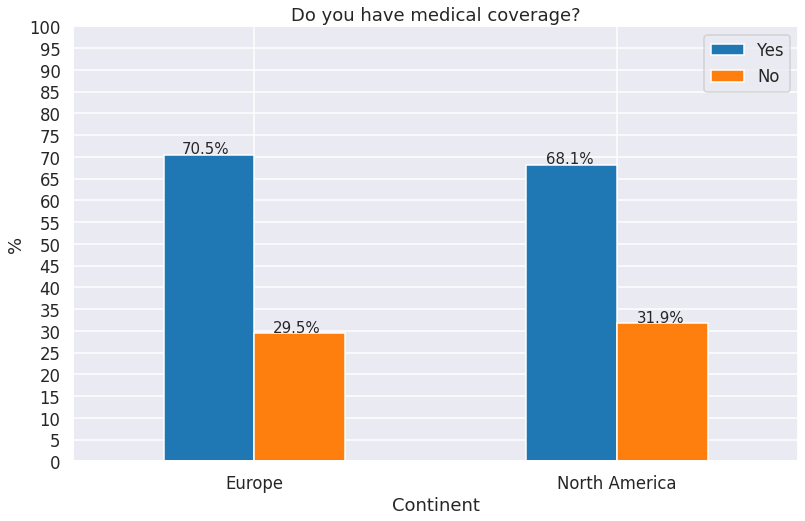

In [ ]:
ax = cov_plot.plot(kind='bar', stacked=False, figsize=(13, 8))

for p in ax.patches:
    ax.annotate(str(p.get_height())+'%',
                (p.get_x() * 1.005+0.05, p.get_height() * 1.005+0.02), fontsize=15)

plt.ylabel('%')
plt.yticks(np.arange(0, 105, 5))
plt.xticks(rotation=0, ha='center')
plt.legend(labels=['Yes', 'No'])
plt.title('Do you have medical coverage?')
plt.show()

Surprisingly enough almost the same percentage of Americans have medical coverage as Europeans.

### Mental vs Physical health

#### Average rating over the years

The importance of mental health in today's society is getting bigger as we get more and more information about it and more usually people acknowleadge it as a serious thing. Let's look how the rating of mental health importance to employers changed 2017-2019. 

In [ ]:
rating_years = qna_df.loc[qna_df['questionid'] == 65][['UserID', 'SurveyID', 'AnswerText']] 
rating_years_cont = pd.merge(country_continent, rating_years,
                             how='inner', on='UserID')

In [ ]:
rating_years_cont['AnswerText_y'] = rating_years_cont['AnswerText_y'].astype('int')

In [ ]:
rating_years_plot = (rating_years_cont
                     .groupby(['SurveyID', 'Continent'])['AnswerText_y']
                     .mean().round(1).unstack())

In [ ]:
rating_years_plot

Continent,Europe,North America
SurveyID,,
2017,5.0,5.1
2018,5.0,4.8
2019,5.1,5.0


European average rating grew up by 0.1 while North Americas after jumping down and up decreased by 0.1.

#### How important mental health is for employer

In [ ]:
mental_rating = find_answers(65)

In [ ]:
mental_rating_df = (pd.merge(merged_benefits, mental_rating, 
                             how='inner', on='UserID'))

In [ ]:
mental_rating_df['AnswerText'] = mental_rating_df['AnswerText'].astype('int')

In [ ]:
plot_mental = (mental_rating_df
               .groupby(['AnswerText_x_x', 'Continent'])['AnswerText']
               .mean().round(1).unstack())

In [ ]:
plot_mental = plot_mental.reindex(index=["1-5", "6-25",
                                         "26-100", "100-500",
                                         "500-1000", "more than 1000"])

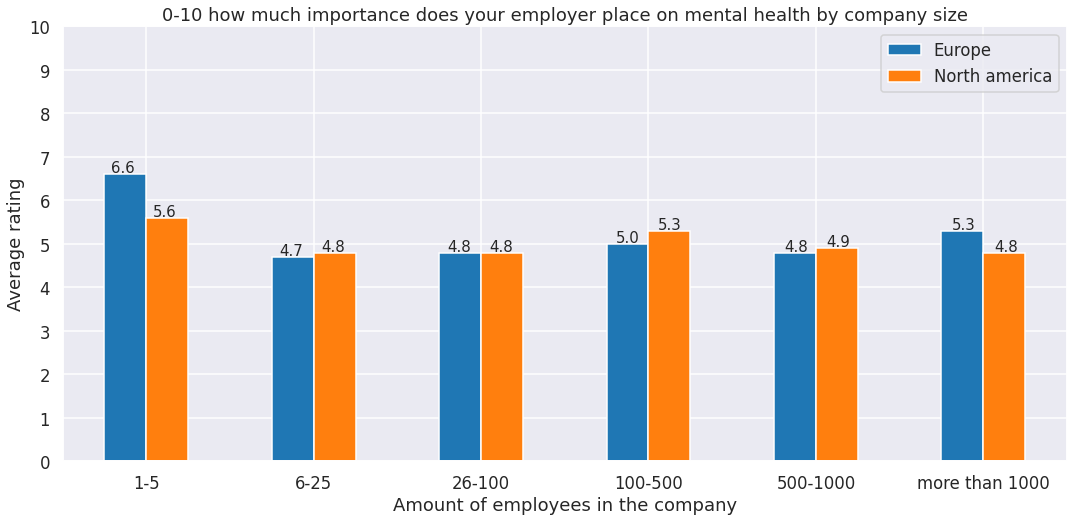

In [ ]:
grouped_bar_chart(plot_mental, 18, 8,
                  '0-10 how much importance does your employer place on mental health by company size',
                  'Amount of employees in the company', 'Average rating',
                  np.arange(0, 11, 1), 0.04, 15, '')

We see that in Europe companies sized '1-5' and 'more than 1000' employees have higher ratings than in North America. North America has a relatively bigger rating in '100-500' size companies. Other sizes are pretty much even.

If bigger companies have mental health benefits provided more oftenly we could assume that survey participants would think that their employer cares more about mental health when comparing to smaller companies. Well that's not the case here. All average ratings are relatively close to one another. 

#### How important physical health is for employer

Let's look at the ratings of physical health importance.

In [ ]:
physical_rating = find_answers(64)
physical_rating_df = pd.merge(merged_benefits, physical_rating,
                              how='inner', on='UserID')
physical_rating_df['AnswerText'] = physical_rating_df['AnswerText'].astype('int')

In [ ]:
plot_physical = (physical_rating_df
                 .groupby(['AnswerText_x_x', 'Continent'])['AnswerText']
                 .mean().round(1).unstack())

In [ ]:
plot_physical = plot_physical.reindex(index=["1-5", "6-25", 
                                             "26-100", "100-500", 
                                             "500-1000", 
                                             "more than 1000"])

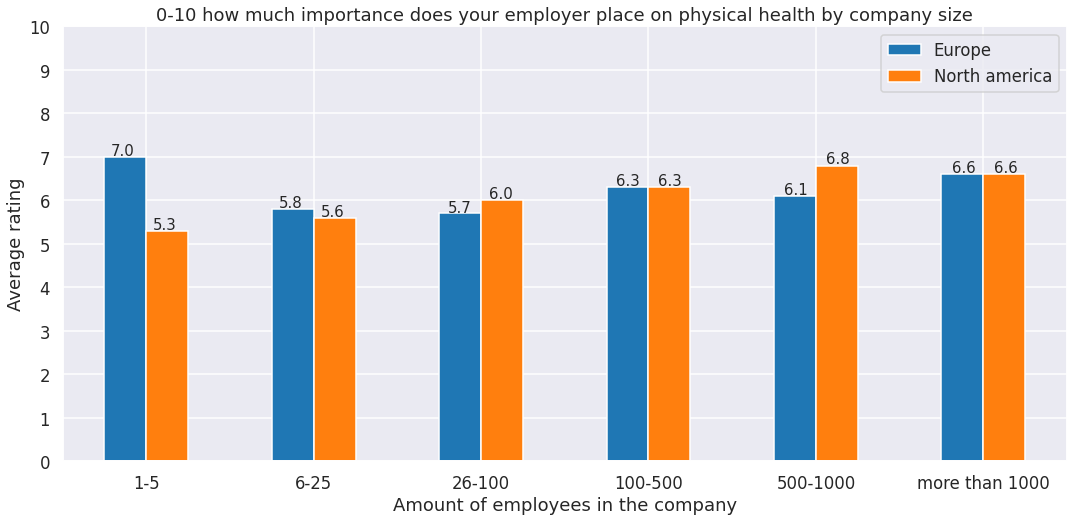

In [ ]:
grouped_bar_chart(plot_physical, 18, 8,
                  '0-10 how much importance does your employer place on physical health by company size',
                  'Amount of employees in the company', 'Average rating',
                  np.arange(0, 11, 1), 0.04, 15, '')

By average ratings we see that survey participants think that employers care more about physical rather than mental health. Also we see a tendency in North America that the more employees a company has the higher rating for physical health importance to employer it has.

### Talking about mental health problems

It's not only the ratings that are important when trying to figure out if employers care much about mental health. We have to evaluate how employers themselves act and where they stand on mental health importance at work.

In [ ]:
discussed_answer = find_answers(15).dropna()

In [ ]:
discussed_answer = pd.merge(country_continent, discussed_answer,
                            how='inner', on='UserID')

In [ ]:
discussed_group = (discussed_answer
                   .groupby('Continent')['AnswerText_y']
                   .value_counts(normalize=True)*100).round(1)

In [ ]:
discussed_plot = (discussed_group.unstack()
                  .reindex(columns=["yes","no", "i don't know"]))

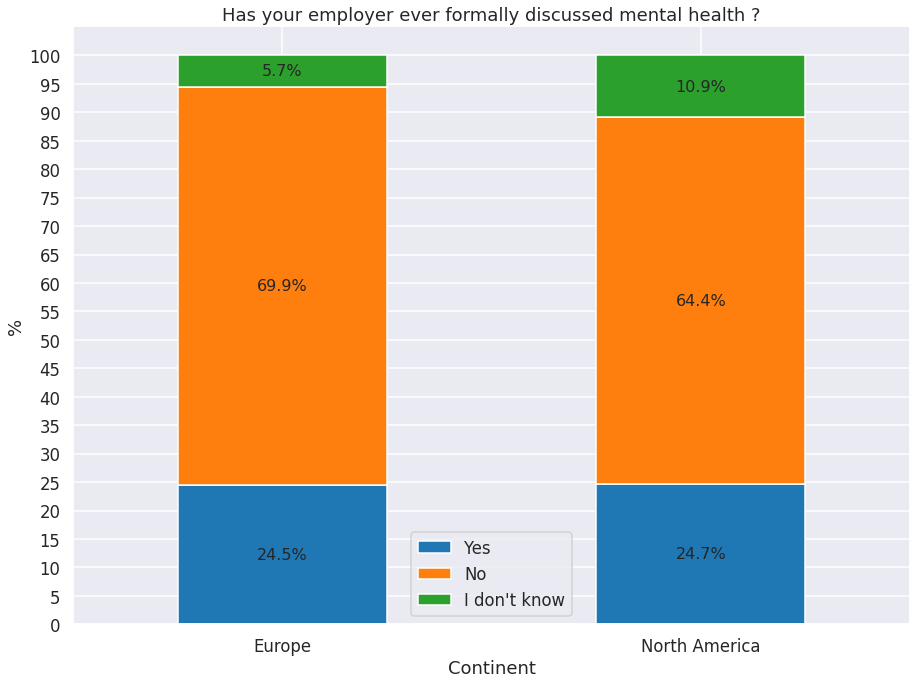

In [ ]:
stacked_bar_chart(discussed_plot, 15, 11, 
                  'Has your employer ever formally discussed mental health ?',
                  np.arange(0, 105, 5), '%', discussed_plot.columns.str
                  .capitalize())

This graph also shows us that European and American employers care pretty much the same about mental health problems. The problem I see that the percentage of employers who discussed mental health is quite low when we have in mind that 50% of Europeans and 70%+ of Americans say that they have mental health issues.

#### Talking about mental health with direct supervisors

It is important to know how the employees in EU and NA feel about discussing mental health at work.

In [ ]:
supervisors_answer = find_answers(19)

In [ ]:
supervisors_answer = pd.merge(country_continent, supervisors_answer,
                              how='inner', on='UserID')

In [ ]:
supervisors_group = (supervisors_answer
                     .groupby('Continent')['AnswerText_y']
                     .value_counts(normalize=True)*100).round(1)

In [ ]:
supervisors_group = supervisors_group.unstack().reindex(columns=["yes","no","maybe"])

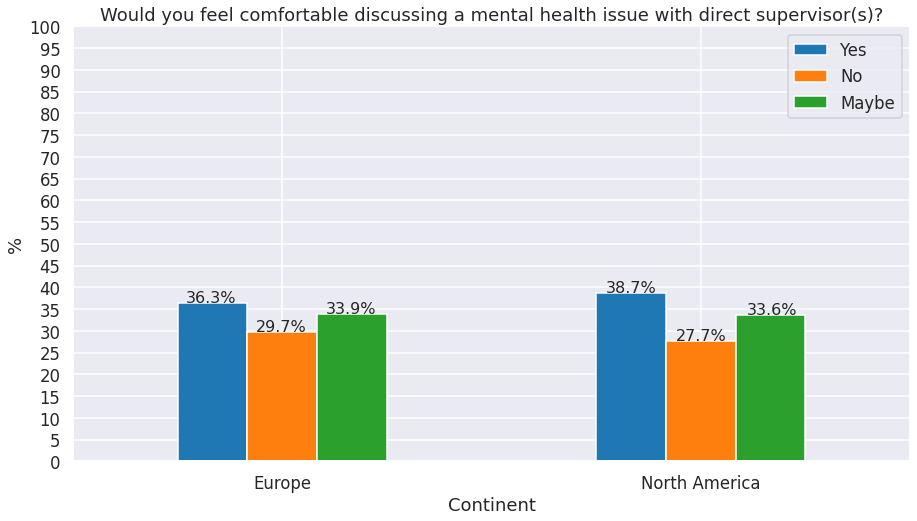

In [ ]:
grouped_bar_chart(supervisors_group, 15, 8,
                  'Would you feel comfortable discussing a mental health issue with direct supervisor(s)?',
                  'Continent', '%', np.arange(0, 105, 5), 0.02, 16, '%')

Europeans when talking to their supervisors are little bit less likely to speak their mind about mental health compared to Americans but the percentages overall are quite similar. 

#### Talking about mental health with colleagues

Speaking about mental health to the supervisors are one thing and speaking to fellow coworkers is another.

In [ ]:
coworkers_answer = find_answers(18)

In [ ]:
coworkers_answer = pd.merge(country_continent, coworkers_answer,
                            how='inner', on='UserID')

In [ ]:
coworkers_group = (coworkers_answer
                   .groupby('Continent')['AnswerText_y']
                   .value_counts(normalize=True)*100).round(1)

In [ ]:
coworkers_group = coworkers_group.unstack().reindex(columns=["yes","no","maybe"])

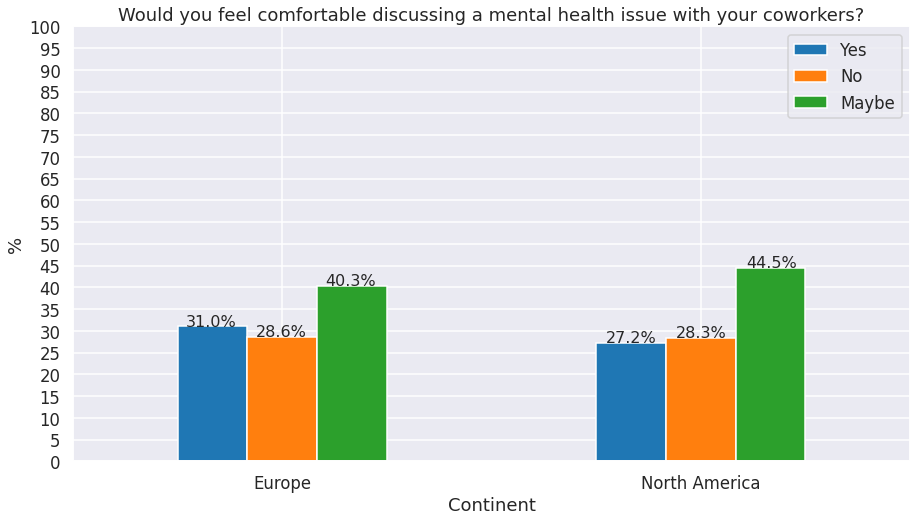

In [ ]:
grouped_bar_chart(coworkers_group, 15, 8,
                  'Would you feel comfortable discussing a mental health issue with your coworkers?',
                  'Continent', '%', np.arange(0, 105, 5), 0.02, 16, '%')

Here we see that Europeans are a little bit more conviced that they would feel comfortable talking about their mental health issues with their colleagues. It is interesting to see that overall a bigger percentage of people wouldn't be so sure about feeling comfortable discussing mental heatlth issues with their colleagues compared to discussing them with supervisors.

#### Bringing up mental issues in an interview

In [ ]:
interview_answer = find_answers(12)

In [ ]:
interview_answer = pd.merge(country_continent, interview_answer,
                            how='inner', on='UserID')

In [ ]:
interview_group = (interview_answer
                   .groupby('Continent')['AnswerText_y']
                   .value_counts(normalize=True)*100).round(1)

In [ ]:
interview_plot = interview_group.unstack().reindex(columns=["yes","no","maybe"])

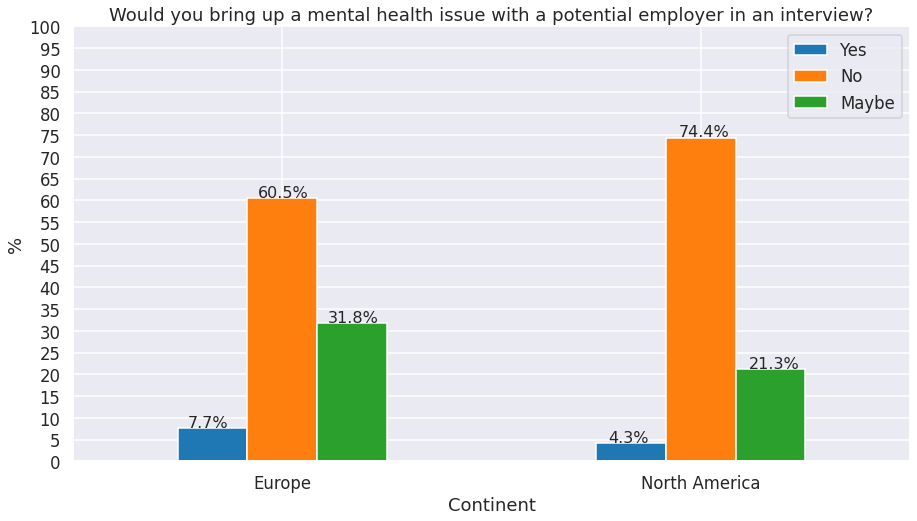

In [ ]:
grouped_bar_chart(interview_plot, 15, 8,
                  'Would you bring up a mental health issue with a potential employer in an interview?',
                  'Continent', '%', np.arange(0, 105, 5), 0.025, 16, '%')

On this matter we see that Americans are more insecure when discussing their mental health problems during and interview, bigger percentage of them said that they wouldn't mention mental disorders while bigger portion of Europeans maybe/would mention it.

#### Would you rather

Even these days many people are afraid of talking about mental health problems and definitely would rather speak about physical health.

In [ ]:
preference = find_answers(57)

In [ ]:
preference_p = preference['AnswerText'].value_counts()

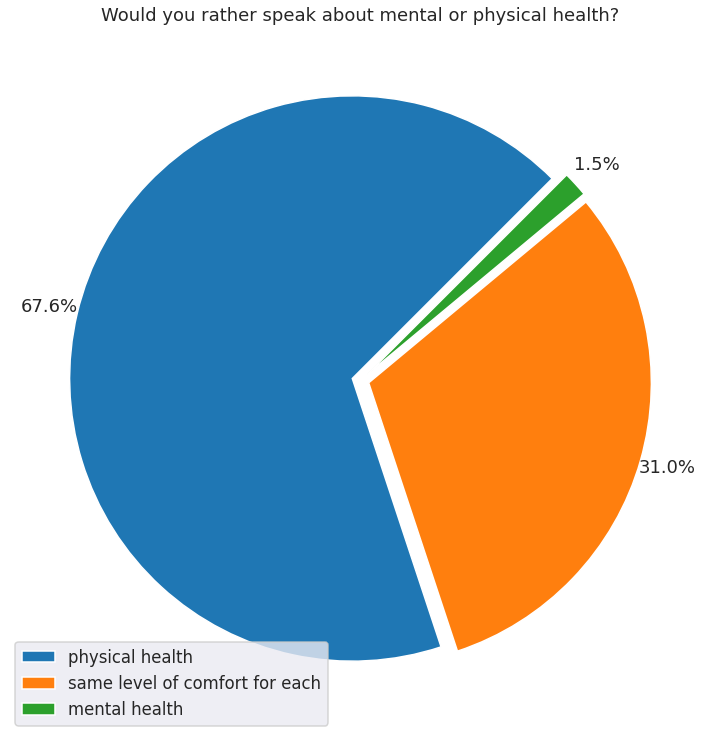

In [ ]:
fig=plt.figure(figsize=(13,13))
data=preference_p.values
labels=preference_p.index

colors=sns.color_palette()

plt.pie(preference_p,
        colors=colors,
        autopct='%.1f%%',
        startangle=45,
        pctdistance=1.1,
        explode=[0.03]*len(preference_p.index),
        )
plt.title(f'Would you rather speak about mental or physical health?')
plt.legend(labels=labels, loc='lower left')

plt.show()

We see that roughly 2 out of 3 people would rather speak about physical health than mental health. About 3 out of 10 people have the same confidence to talk about both.

In [ ]:
comfort_continent = pd.merge(country_continent, preference,
                             how='inner', on='UserID')

In [ ]:
(comfort_continent
 .groupby('Continent')['AnswerText_y']
 .value_counts(normalize=True)*100).round(1)

Continent      AnswerText_y                  
Europe         physical health                   70.7
               same level of comfort for each    27.0
               mental health                      2.3
North America  physical health                   67.4
               same level of comfort for each    31.9
               mental health                      0.7
Name: AnswerText_y, dtype: float64

Looking at the differences between Europe and North America on this matter, there aren't any of significance. Both continents are fairy similar.

### Do mental health problems interfere with work?

In [ ]:
interference = find_answers(49)

In [ ]:
interference = pd.merge(country_continent, interference,
                        how='inner', on='UserID')

In [ ]:
interference.drop(interference[interference['AnswerText_y'] == 'not applicable to me'].index, inplace=True)

In [ ]:
interference_group = (interference.groupby('Continent')['AnswerText_y']
                      .value_counts(normalize=True)*100).round(1)

In [ ]:
interference_group = (interference_group
                      .unstack()
                      .reindex(columns=["often","sometimes","rarely","never"]))

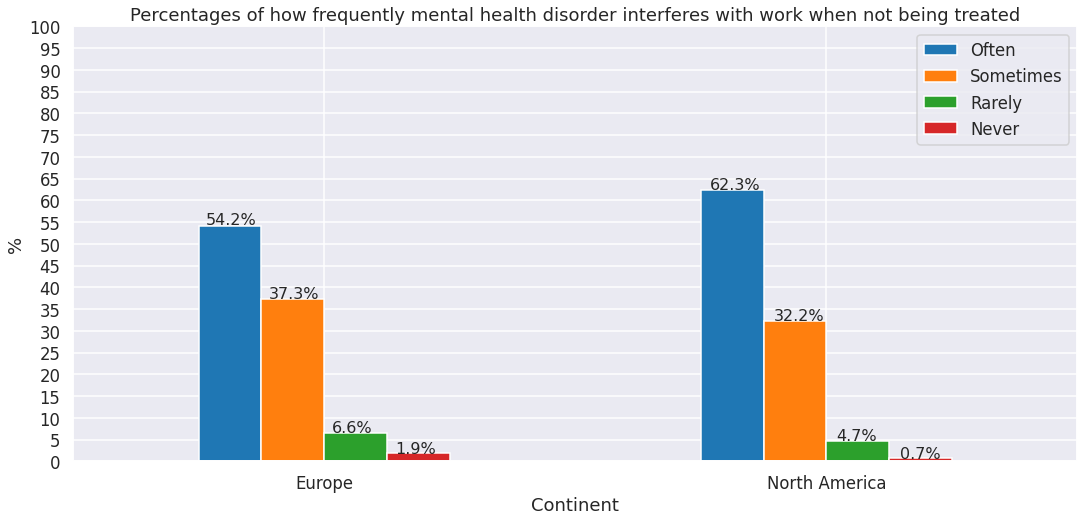

In [ ]:
grouped_bar_chart(interference_group, 18, 8,
                  'Percentages of how frequently mental health disorder interferes with work when not being treated',
                  'Continent', '%', np.arange(0, 105, 5), 0.015, 16, '%') 

Slightly less Europeans answered that mental disorders interfere 'often', more of them said 'sometimes' comparing to North Americans. We can say that both continents have similar percentages on how often mental health disorders interfere with work when not being treated.

### If a mental health issue prompted you to request a medical leave from work, how easy or difficult would it be to ask for that leave?

In [ ]:
difficulty_leaving = find_answers(17)

In [ ]:
difficulty_leaving = pd.merge(country_continent, difficulty_leaving,
                              how='inner', on='UserID')

In [ ]:
difficulty_leaving_plot = (difficulty_leaving
                           .groupby('Continent')['AnswerText_y']
                           .value_counts(normalize=True)*100).round(1)

In [ ]:
difficulty_leaving_plot = (difficulty_leaving_plot.unstack()
.reindex(columns=["very easy","somewhat easy",
                  "neither easy nor difficult",
                  "somewhat difficult", "difficult", 
                  "very difficult", "i don't know"]))

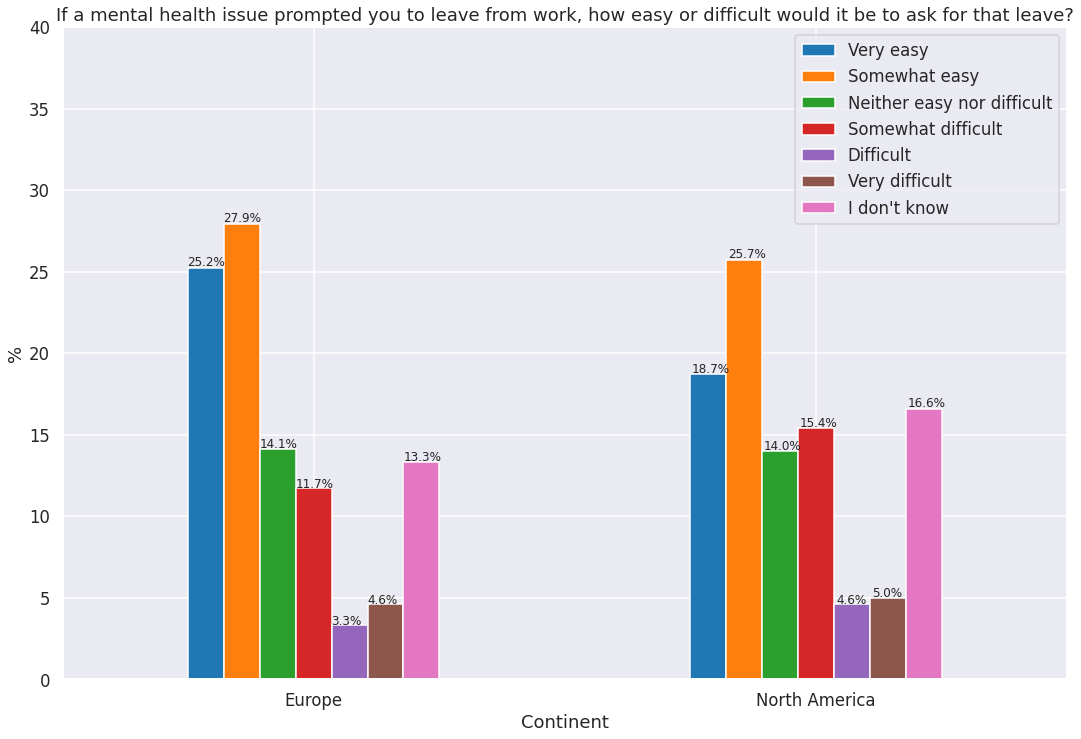

In [ ]:
grouped_bar_chart(difficulty_leaving_plot, 18, 12,
                  'If a mental health issue prompted you to leave from work, how easy or difficult would it be to ask for that leave?',
                  'Continent', '%', np.arange(0, 45, 5), -0.001, 12, '%')

53%+ of Europeans said that it would be easy for them to leave work due to mental health problems compared to 44% of Americans.

### Where to seek help ?

It is important to know where to find help at all times. Let's compare European and American knowleadge about resources of seeking help for a mental health issue.

In [ ]:
seek_help = find_answers(21)

In [ ]:
seek_help_df = pd.merge(country_continent, seek_help,
                        how='inner', on='UserID')

In [ ]:
seek_help_plot = (seek_help_df.groupby('Continent')['AnswerText_y']
                  .value_counts(normalize=True)*100).round(1)

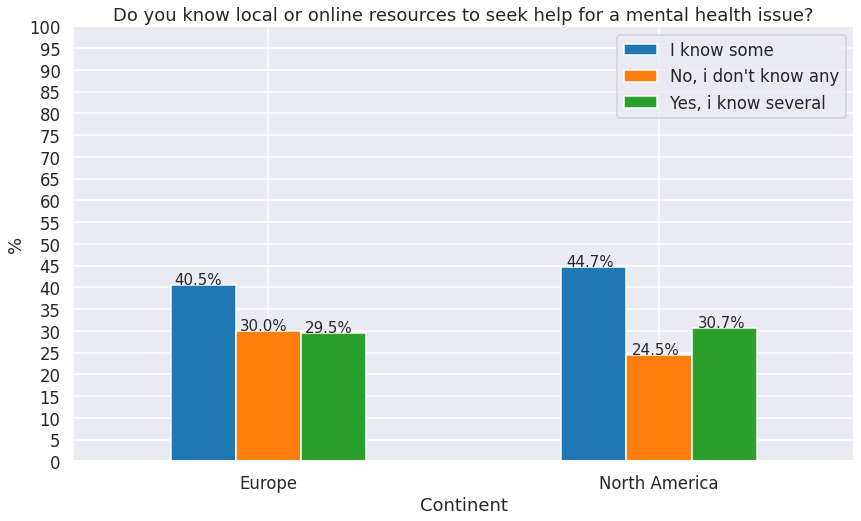

In [ ]:
grouped_bar_chart(seek_help_plot.unstack(), 14, 8,
                  'Do you know local or online resources to seek help for a mental health issue?',
                  'Continent', '%', np.arange(0, 105, 5), 0.01, 15, '%')

We see that bigger percentage of Americans know where to seek help. This is where Europe should step up to lower the people who doesn't know percentage.

## Conclusion

Mental health problems are a big issue in today's society. Many people have them, some inherited them from their parents/grandparents, some don't even know they have them. Mental disorders disrupts efficient work, but companies still care more about physical health, people still aren't as comfortable talking about mental health as they are about physical health. 

Whether Europe or North America is more advanced in regards of mental health culture I would say they're really similar in most aspects. I would say Europeans have a slight advantage when talking about mental health disorders, they are more open to it but bigger percentage of Americans know where to seek help.

# What could be improved?

- More storytelling, better insights, deeper dives
- Bigger variety of graphs
- Better topic to explore (?)
- No unsupervised ML part